# Import Libraries

In [70]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
import calmap
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from wordcloud import WordCloud
import folium
from folium.plugins import HeatMap, HeatMapWithTime, MarkerCluster
from branca.element import Figure
import math



# Extract Transform Load (ETL)

In [2]:
df = pd.read_csv('Raw_Data/datasets_723010_1257097_fatal-police-shootings-data.csv', index_col = 'id')

df.head()

name        date   manner_of_death       armed   age gender  \
id                                                                              
3           Tim Elliot  2015-01-02              shot         gun  53.0      M   
4     Lewis Lee Lembke  2015-01-02              shot         gun  47.0      M   
5   John Paul Quintero  2015-01-03  shot and Tasered     unarmed  23.0      M   
8      Matthew Hoffman  2015-01-04              shot  toy weapon  32.0      M   
9    Michael Rodriguez  2015-01-04              shot    nail gun  39.0      M   

   race           city state  signs_of_mental_illness threat_level  \
id                                                                   
3     A        Shelton    WA                     True       attack   
4     W          Aloha    OR                    False       attack   
5     H        Wichita    KS                    False        other   
8     W  San Francisco    CA                     True       attack   
9     H          Evans    CO                    False       attack   

           flee  body_camera  
id                            
3   Not fleeing        False  
4   Not fleeing        False  
5   Not fleeing        False  
8   Not fleeing        False  
9   Not fleeing        False

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5416 entries, 3 to 5927
Data columns (total 13 columns):
name                       5416 non-null object
date                       5416 non-null object
manner_of_death            5416 non-null object
armed                      5189 non-null object
age                        5181 non-null float64
gender                     5414 non-null object
race                       4895 non-null object
city                       5416 non-null object
state                      5416 non-null object
signs_of_mental_illness    5416 non-null bool
threat_level               5416 non-null object
flee                       5167 non-null object
body_camera                5416 non-null bool
dtypes: bool(2), float64(1), object(10)
memory usage: 518.3+ KB


In [4]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

# Given the current climate on police brutality, it's concerning that race has the most null values. 
#This further compounds the fact law enforcement agencies are purposely hiding race to deflate 
#Since each column with null values is less than 10% then we can continue with dropping those rows since it wont impact the analysis too much


column_name  percent_missing
name                                        name         0.000000
date                                        date         0.000000
manner_of_death                  manner_of_death         0.000000
armed                                      armed         4.191285
age                                          age         4.338996
gender                                    gender         0.036928
race                                        race         9.619645
city                                        city         0.000000
state                                      state         0.000000
signs_of_mental_illness  signs_of_mental_illness         0.000000
threat_level                        threat_level         0.000000
flee                                        flee         4.597489
body_camera                          body_camera         0.000000

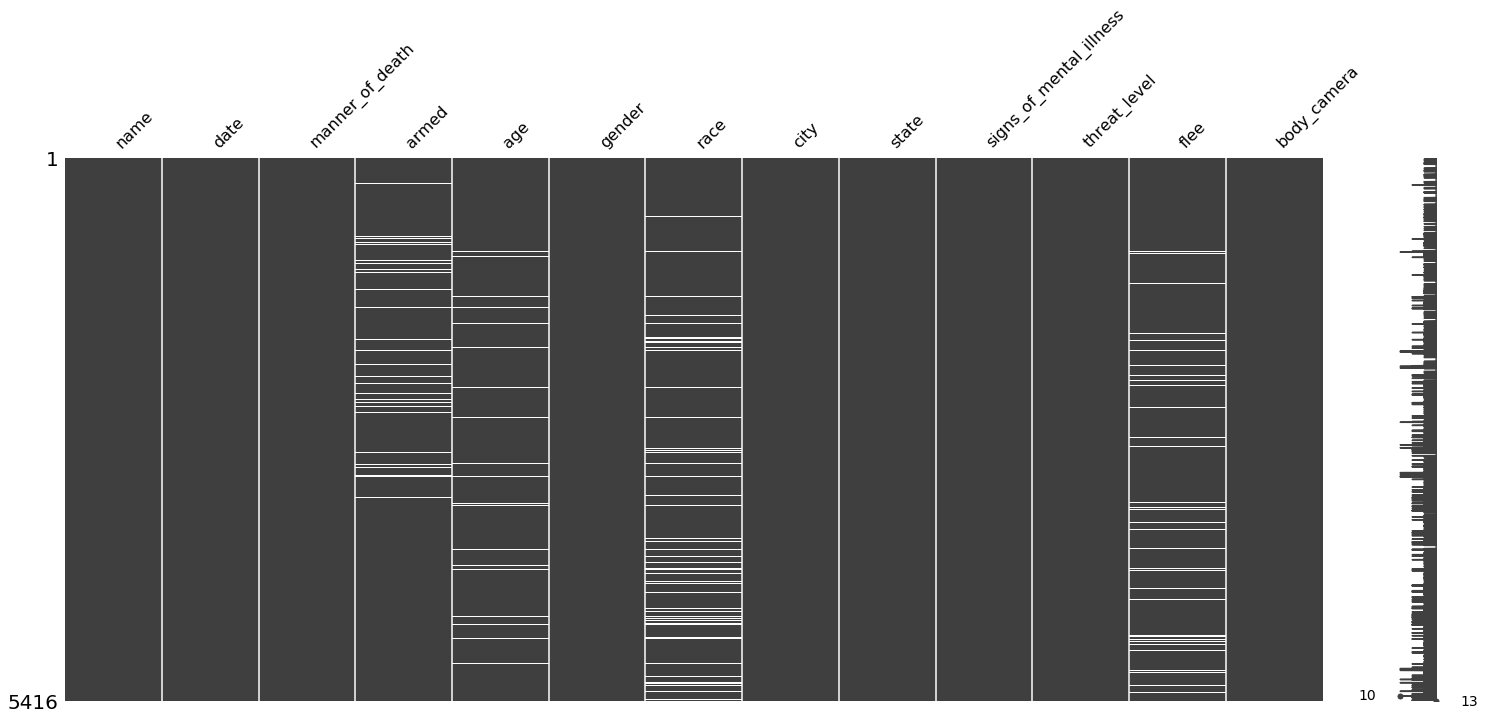

In [5]:
msno.matrix(df)

### Drop all rows with NaN values 

In [6]:
df_clean = df.dropna(how='any')

df_clean.shape

(4399, 13)

### Check data types of each column - Time needs to be changed to Datetime

In [7]:
df_clean.dtypes

name                        object
date                        object
manner_of_death             object
armed                       object
age                        float64
gender                      object
race                        object
city                        object
state                       object
signs_of_mental_illness       bool
threat_level                object
flee                        object
body_camera                   bool
dtype: object

### Extract day, month, year out of date for more granular analysis 

In [8]:
df_clean['date'] = pd.to_datetime(df_clean['date'])
df_clean['day'] = pd.to_datetime(df_clean['date']).dt.day
df_clean['month'] = pd.to_datetime(df_clean['date']).dt.month
df_clean['year'] = pd.to_datetime(df_clean['date']).dt.year
df_clean['date_mon']=df_clean.date.dt.to_period("M")
df_clean['date_num']=df_clean['date'].dt.strftime('%d').astype(int)
df_clean['day_of_week']=df_clean['date'].dt.strftime('%A')  

df_clean['portion_month']=np.where(df_clean['date_num']<16,"First Half","Second Half")
df_clean

C:\Users\alao8\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\alao8\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\alao8\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

name       date   manner_of_death  \
id                                                                    
3                           Tim Elliot 2015-01-02              shot   
4                     Lewis Lee Lembke 2015-01-02              shot   
5                   John Paul Quintero 2015-01-03  shot and Tasered   
8                      Matthew Hoffman 2015-01-04              shot   
9                    Michael Rodriguez 2015-01-04              shot   
11                   Kenneth Joe Brown 2015-01-04              shot   
13                 Kenneth Arnold Buck 2015-01-05              shot   
15                       Brock Nichols 2015-01-06              shot   
16                       Autumn Steele 2015-01-06              shot   
17                     Leslie Sapp III 2015-01-06              shot   
19                      Patrick Wetter 2015-01-06  shot and Tasered   
21                           Ron Sneed 2015-01-07              shot   
22      Hashim Hanif Ibn Abdul-Rasheed 2015-01-07              shot   
25              Nicholas Ryan Brickman 2015-01-07              shot   
27    Omarr Julian Maximillian Jackson 2015-01-07              shot   
32                 James Dudley Barker 2015-01-08              shot   
36                 Artago Damon Howard 2015-01-08              shot   
37                        Thomas Hamby 2015-01-08              shot   
38                       Jimmy Foreman 2015-01-09              shot   
325                      Andy Martinez 2015-01-09              shot   
42                         Tommy Smith 2015-01-11              shot   
43                      Brian  Barbosa 2015-01-11              shot   
45                   Salvador Figueroa 2015-01-11  shot and Tasered   
46                 John Edward O'Keefe 2015-01-13              shot   
48                   Richard McClendon 2015-01-13              shot   
51                        Mario Jordan 2015-01-14              shot   
52                    Talbot Schroeder 2015-01-14              shot   
54                      Robert Edwards 2015-01-14              shot   
55                  Jeffrey R. Nielson 2015-01-14              shot   
56                        Donte Sowell 2015-01-15              shot   
...                                ...        ...               ...   
5858                  Hector Hernandez 2020-05-27              shot   
5846                     Modesto Reyes 2020-05-27  shot and Tasered   
5853             John Benedict Coleman 2020-05-28              shot   
5855            Steven Edward Ferguson 2020-05-28              shot   
5906                       Ruben Smith 2020-05-28              shot   
5844             Heba Momtaz Al-Azhari 2020-05-29              shot   
5850               Momodou Lamin Sisay 2020-05-29              shot   
5879                   Jarvis Sullivan 2020-05-29              shot   
5863                  Derrick Thompson 2020-05-30              shot   
5878                  Thomas Sutherlin 2020-05-31  shot and Tasered   
5866                       Jorge Gomez 2020-06-01              shot   
5867                 Ryan Emblem Moore 2020-06-01              shot   
5896                   Sean Monterrosa 2020-06-02              shot   
5897                    Tyquarn Graves 2020-06-02              shot   
5898                     Mary Lawrence 2020-06-03              shot   
5902               Gregory W. Hallback 2020-06-03              shot   
5904                    Eric A. Galvan 2020-06-03              shot   
5905             Scott Anderson Hutton 2020-06-03              shot   
5903                  Benjamin Ballard 2020-06-05              shot   
5899                     Kamal Flowers 2020-06-06              shot   
5900                      Erik Salgado 2020-06-06              shot   
5908                      Jarrid Hurst 2020-06-07              shot   
5913              Gregorio Cruz Vanloo 2020-06-11              shot   
5914                  Mason James Lira 2020-06-11         

### Change the race column to more informative text

In [9]:
# df_clean.race.unique()
race_cat = {'A': 'Asian', 'W':'White', 'H': 'Hispanic', 'B':'Black', 'O':'Other', 'N':'Native American'}

df_clean['race'] = df_clean['race'].map(race_cat)
df_clean

C:\Users\alao8\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



name       date   manner_of_death  \
id                                                                    
3                           Tim Elliot 2015-01-02              shot   
4                     Lewis Lee Lembke 2015-01-02              shot   
5                   John Paul Quintero 2015-01-03  shot and Tasered   
8                      Matthew Hoffman 2015-01-04              shot   
9                    Michael Rodriguez 2015-01-04              shot   
11                   Kenneth Joe Brown 2015-01-04              shot   
13                 Kenneth Arnold Buck 2015-01-05              shot   
15                       Brock Nichols 2015-01-06              shot   
16                       Autumn Steele 2015-01-06              shot   
17                     Leslie Sapp III 2015-01-06              shot   
19                      Patrick Wetter 2015-01-06  shot and Tasered   
21                           Ron Sneed 2015-01-07              shot   
22      Hashim Hanif Ibn Abdul-Rasheed 2015-01-07              shot   
25              Nicholas Ryan Brickman 2015-01-07              shot   
27    Omarr Julian Maximillian Jackson 2015-01-07              shot   
32                 James Dudley Barker 2015-01-08              shot   
36                 Artago Damon Howard 2015-01-08              shot   
37                        Thomas Hamby 2015-01-08              shot   
38                       Jimmy Foreman 2015-01-09              shot   
325                      Andy Martinez 2015-01-09              shot   
42                         Tommy Smith 2015-01-11              shot   
43                      Brian  Barbosa 2015-01-11              shot   
45                   Salvador Figueroa 2015-01-11  shot and Tasered   
46                 John Edward O'Keefe 2015-01-13              shot   
48                   Richard McClendon 2015-01-13              shot   
51                        Mario Jordan 2015-01-14              shot   
52                    Talbot Schroeder 2015-01-14              shot   
54                      Robert Edwards 2015-01-14              shot   
55                  Jeffrey R. Nielson 2015-01-14              shot   
56                        Donte Sowell 2015-01-15              shot   
...                                ...        ...               ...   
5858                  Hector Hernandez 2020-05-27              shot   
5846                     Modesto Reyes 2020-05-27  shot and Tasered   
5853             John Benedict Coleman 2020-05-28              shot   
5855            Steven Edward Ferguson 2020-05-28              shot   
5906                       Ruben Smith 2020-05-28              shot   
5844             Heba Momtaz Al-Azhari 2020-05-29              shot   
5850               Momodou Lamin Sisay 2020-05-29              shot   
5879                   Jarvis Sullivan 2020-05-29              shot   
5863                  Derrick Thompson 2020-05-30              shot   
5878                  Thomas Sutherlin 2020-05-31  shot and Tasered   
5866                       Jorge Gomez 2020-06-01              shot   
5867                 Ryan Emblem Moore 2020-06-01              shot   
5896                   Sean Monterrosa 2020-06-02              shot   
5897                    Tyquarn Graves 2020-06-02              shot   
5898                     Mary Lawrence 2020-06-03              shot   
5902               Gregory W. Hallback 2020-06-03              shot   
5904                    Eric A. Galvan 2020-06-03              shot   
5905             Scott Anderson Hutton 2020-06-03              shot   
5903                  Benjamin Ballard 2020-06-05              shot   
5899                     Kamal Flowers 2020-06-06              shot   
5900                      Erik Salgado 2020-06-06              shot   
5908                      Jarrid Hurst 2020-06-07              shot   
5913              Gregorio Cruz Vanloo 2020-06-11              shot   
5914                  Mason James Lira 2020-06-11         

In [10]:
months = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5: "May", 6: 'Jun',
          7: 'Jul', 8: 'Aug', 9: "Sept", 10: 'Oct', 11:'Nov', 12:'Dec'}
df_clean['month'] = df_clean['month'].map(months)

df_clean

C:\Users\alao8\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



name       date   manner_of_death  \
id                                                                    
3                           Tim Elliot 2015-01-02              shot   
4                     Lewis Lee Lembke 2015-01-02              shot   
5                   John Paul Quintero 2015-01-03  shot and Tasered   
8                      Matthew Hoffman 2015-01-04              shot   
9                    Michael Rodriguez 2015-01-04              shot   
11                   Kenneth Joe Brown 2015-01-04              shot   
13                 Kenneth Arnold Buck 2015-01-05              shot   
15                       Brock Nichols 2015-01-06              shot   
16                       Autumn Steele 2015-01-06              shot   
17                     Leslie Sapp III 2015-01-06              shot   
19                      Patrick Wetter 2015-01-06  shot and Tasered   
21                           Ron Sneed 2015-01-07              shot   
22      Hashim Hanif Ibn Abdul-Rasheed 2015-01-07              shot   
25              Nicholas Ryan Brickman 2015-01-07              shot   
27    Omarr Julian Maximillian Jackson 2015-01-07              shot   
32                 James Dudley Barker 2015-01-08              shot   
36                 Artago Damon Howard 2015-01-08              shot   
37                        Thomas Hamby 2015-01-08              shot   
38                       Jimmy Foreman 2015-01-09              shot   
325                      Andy Martinez 2015-01-09              shot   
42                         Tommy Smith 2015-01-11              shot   
43                      Brian  Barbosa 2015-01-11              shot   
45                   Salvador Figueroa 2015-01-11  shot and Tasered   
46                 John Edward O'Keefe 2015-01-13              shot   
48                   Richard McClendon 2015-01-13              shot   
51                        Mario Jordan 2015-01-14              shot   
52                    Talbot Schroeder 2015-01-14              shot   
54                      Robert Edwards 2015-01-14              shot   
55                  Jeffrey R. Nielson 2015-01-14              shot   
56                        Donte Sowell 2015-01-15              shot   
...                                ...        ...               ...   
5858                  Hector Hernandez 2020-05-27              shot   
5846                     Modesto Reyes 2020-05-27  shot and Tasered   
5853             John Benedict Coleman 2020-05-28              shot   
5855            Steven Edward Ferguson 2020-05-28              shot   
5906                       Ruben Smith 2020-05-28              shot   
5844             Heba Momtaz Al-Azhari 2020-05-29              shot   
5850               Momodou Lamin Sisay 2020-05-29              shot   
5879                   Jarvis Sullivan 2020-05-29              shot   
5863                  Derrick Thompson 2020-05-30              shot   
5878                  Thomas Sutherlin 2020-05-31  shot and Tasered   
5866                       Jorge Gomez 2020-06-01              shot   
5867                 Ryan Emblem Moore 2020-06-01              shot   
5896                   Sean Monterrosa 2020-06-02              shot   
5897                    Tyquarn Graves 2020-06-02              shot   
5898                     Mary Lawrence 2020-06-03              shot   
5902               Gregory W. Hallback 2020-06-03              shot   
5904                    Eric A. Galvan 2020-06-03              shot   
5905             Scott Anderson Hutton 2020-06-03              shot   
5903                  Benjamin Ballard 2020-06-05              shot   
5899                     Kamal Flowers 2020-06-06              shot   
5900                      Erik Salgado 2020-06-06              shot   
5908                      Jarrid Hurst 2020-06-07              shot   
5913              Gregorio Cruz Vanloo 2020-06-11              shot   
5914                  Mason James Lira 2020-06-11         

In [11]:
df_clean['death_count'] = 1



C:\Users\alao8\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### Average Population for each demographic ( 2015-2019)

In [12]:
pop = pd.read_excel('Raw_Data/Demographic_population.xlsx', index_col = 'Race')

pop_df = pop.mean(axis=1).to_frame().rename(columns={0: 'Count'}).round().astype(int)
pop_sum = pop_df['Count'].sum()

pop_df['% of whole pop'] = ((pop_df/pop_sum) * 100).round(1)

pop_df

Count  % of whole pop
Race                                      
White            249109947            66.7
Black             43336785            11.6
Native American    4098921             1.1
Asian             18687179             5.0
Hispanic          58498253            15.7

### Read in Population of Major Cities 

In [13]:
df_clean = df_clean.rename(columns={'city': 'City'})
city_pop = pd.read_excel('Raw_Data/city_pop_data.xlsx')
city_coords = df_clean.merge(city_pop, how='inner', on= 'City')
city_coords

name       date   manner_of_death  \
0                     Tim Elliot 2015-01-02              shot   
1                Kathryn R. Hale 2020-03-24              shot   
2             John Paul Quintero 2015-01-03  shot and Tasered   
3               Caleb J. Douglas 2016-09-01              shot   
4                 Kevin C. Perry 2017-03-18              shot   
5                     Jose Ortiz 2017-08-07              shot   
6                   Andrew Finch 2017-12-27              shot   
7                Geoffrey Morris 2019-01-10              shot   
8       David Michael Bosiljevac 2019-01-28              shot   
9                    Fred Burton 2019-05-23              shot   
10                Robert Sabater 2019-05-27              shot   
11             Debra D. Arbuckle 2019-12-30              shot   
12               Matthew Hoffman 2015-01-04              shot   
13           Amilcar Perez-Lopez 2015-02-26              shot   
14               Herbert Benitez 2015-10-15              shot   
15           Javier Lopez Garcia 2015-11-11              shot   
16                   Mario Woods 2015-12-02              shot   
17                  Luis Gongora 2016-04-07              shot   
18       Jessica Nelson-Williams 2016-05-19              shot   
19            Nicholas McWherter 2016-10-14              shot   
20              Nicholas Flusche 2017-05-03              shot   
21                      John Eno 2017-05-23              shot   
22                 Damien Murray 2017-09-24              shot   
23                  Keita O'Neil 2017-12-01              shot   
24          Jesus Delgado-Duarte 2018-03-06              shot   
25                     Jehad Eid 2018-03-21              shot   
26           Kenneth Arnold Buck 2015-01-05              shot   
27               Mitchell Oakley 2016-04-23              shot   
28                  Kay Kenniker 2018-10-12              shot   
29           Kevin Alan Smallman 2020-01-27              shot   
...                          ...        ...               ...   
3004               Dominick Matt 2019-12-06              shot   
3005              Mauro Carrillo 2019-12-10              shot   
3006       Montay Steven Penning 2019-12-10              shot   
3007             Francine Graham 2019-12-10              shot   
3008           David N. Anderson 2019-12-10              shot   
3009               Anthony Tovar 2019-12-12              shot   
3010            Christopher Gray 2019-12-19              shot   
3011             Emanuel Johnson 2019-12-19  shot and Tasered   
3012             Emanuel Johnson 2019-12-19  shot and Tasered   
3013           Frederick Perkins 2019-12-31              shot   
3014              Troy Sullenger 2020-01-02              shot   
3015          Brandon D. Roberts 2020-01-05              shot   
3016           Philip Castonguay 2020-04-05              shot   
3017  Drew Nichols Wallas-Flores 2020-01-05              shot   
3018           Jasman Washington 2020-04-16              shot   
3019          Murbarak Soulemane 2020-01-16  shot and Tasered   
3020              Edward Gendron 2020-01-20              shot   
3021          Adam Ray Hernandez 2020-01-22              shot   
3022          Scott Joseph Weber 2020-01-24              shot   
3023                  Donny Leek 2020-05-14              shot   
3024                  Jason Gora 2020-02-02              shot   
3025        Shawn Michael Taylor 2020-02-04              shot   
3026         Kent Richard Kruger 2020-02-27              shot   
3027                 Terry Cagle 2020-03-02              shot   
3028      Deanna Marie Owsianiak 2020-03-26              shot   
3029               Yamil Acevedo 2020-04-06              shot   
3030           Justin Silvernale 2020-04-12              shot   
3031               Steven Taylor 2020-04-18              shot   
3032                 Ruben Smith 2020-05-28              shot   
3033               Kamal Flowers 2020-06-06              shot  

In [14]:
city_coords['Lat'] = city_coords['Coordinates'].str.split(',').apply(lambda x:x[0])
city_coords['Long'] = city_coords['Coordinates'].str.split(',').apply(lambda x:x[1])
coords_df = city_coords[[]]

# Data Analysis

In [15]:
dth_year = df_clean.year.value_counts().reset_index()
df_deaths = dth_year.rename(columns={'index' :'Year',
               'year': 'Number killed'})

df_deaths['Avg killed per day'] = ((df_deaths['Number killed']) / 365).round()
df_deaths = df_deaths.sort_values('Year')
df_deaths.style.background_gradient(cmap= 'Blues')

In [16]:
fig = go.Figure(data=go.Scatter(x = df_deaths['Year'], 
                               y = df_deaths['Number killed'],
                               mode= 'lines+markers',
                               marker_color = 'blue'))

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Deaths - All Years',xaxis_title='Years',
                 yaxis_title='Total number of kills', title_x=0.5)

fig.show()

This graph shows that the rate of killing per year has never looked down except 2016.
It has an average of 983 per year.Almost 1000 people are killed every year.This is so sad to hear.
We are in mid of 2020 and we have already reached 432 death counts as of now.Will this year also be the same story as before?

Text(0.5, 1.0, 'Number killed per month, 2015-2020')

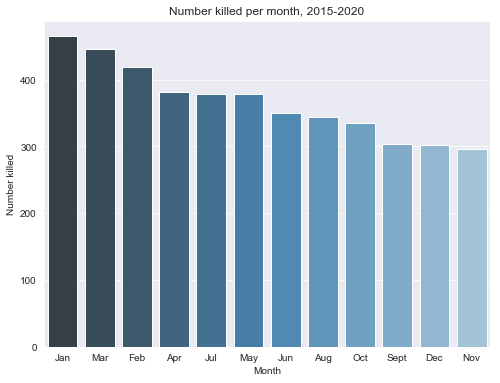

In [17]:
month_deaths = df_clean['month'].value_counts().reset_index()

month_df = month_deaths.rename(columns={'index' :'Month',
               'month': 'Number killed'})
month_df 

plt.figure(figsize=(8,6))

sns.set_style("darkgrid")
sns.barplot(x = "Month", y = "Number killed", data=month_df,palette="Blues_d")
plt.title('Number killed per month, 2015-2020')


In [18]:
# months = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5: "May", 6: 'Jun',
#           7: 'Jul', 8: 'Aug', 9: "Sept", 10: 'Oct', 11:'Nov', 12:'Dec'}

monthly_halfs = df_clean.groupby(['month', 'portion_month'])['name'].agg('count').reset_index().rename(columns={'name':'count'})

# monthly_halfs['month'] = monthly_halfs['month'].map(months)
# monthly_halfs = monthly_halfs.sort_values('month')
# monthly_halfs

fig = go.Figure(data=[
    go.Bar(name='First Half', x=monthly_halfs[monthly_halfs['portion_month'] == 'First Half']['month'],
                                       y = monthly_halfs[monthly_halfs['portion_month'] == 'First Half']['count']), 
    go.Bar(name='Second Half', x=monthly_halfs[monthly_halfs['portion_month'] == 'Second Half']['month'], 
                                       y=monthly_halfs[monthly_halfs['portion_month'] == 'Second Half']['count'])
])

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Deaths - All Months',xaxis_title='Months',
                 yaxis_title='Total number of kills', title_x=0.5,barmode='stack')

fig.show()

As we observed from previous graph,January,February and March have recorded most cases.
The second half of year is low comparitive to the first half.

In [19]:
date_df = df_clean.groupby('date')
date_df = date_df['name'].count()
max_incidents = date_df.max()

print(f"{max_incidents} is the most number of incidents on one day.")


9 is the most number of incidents on one day.


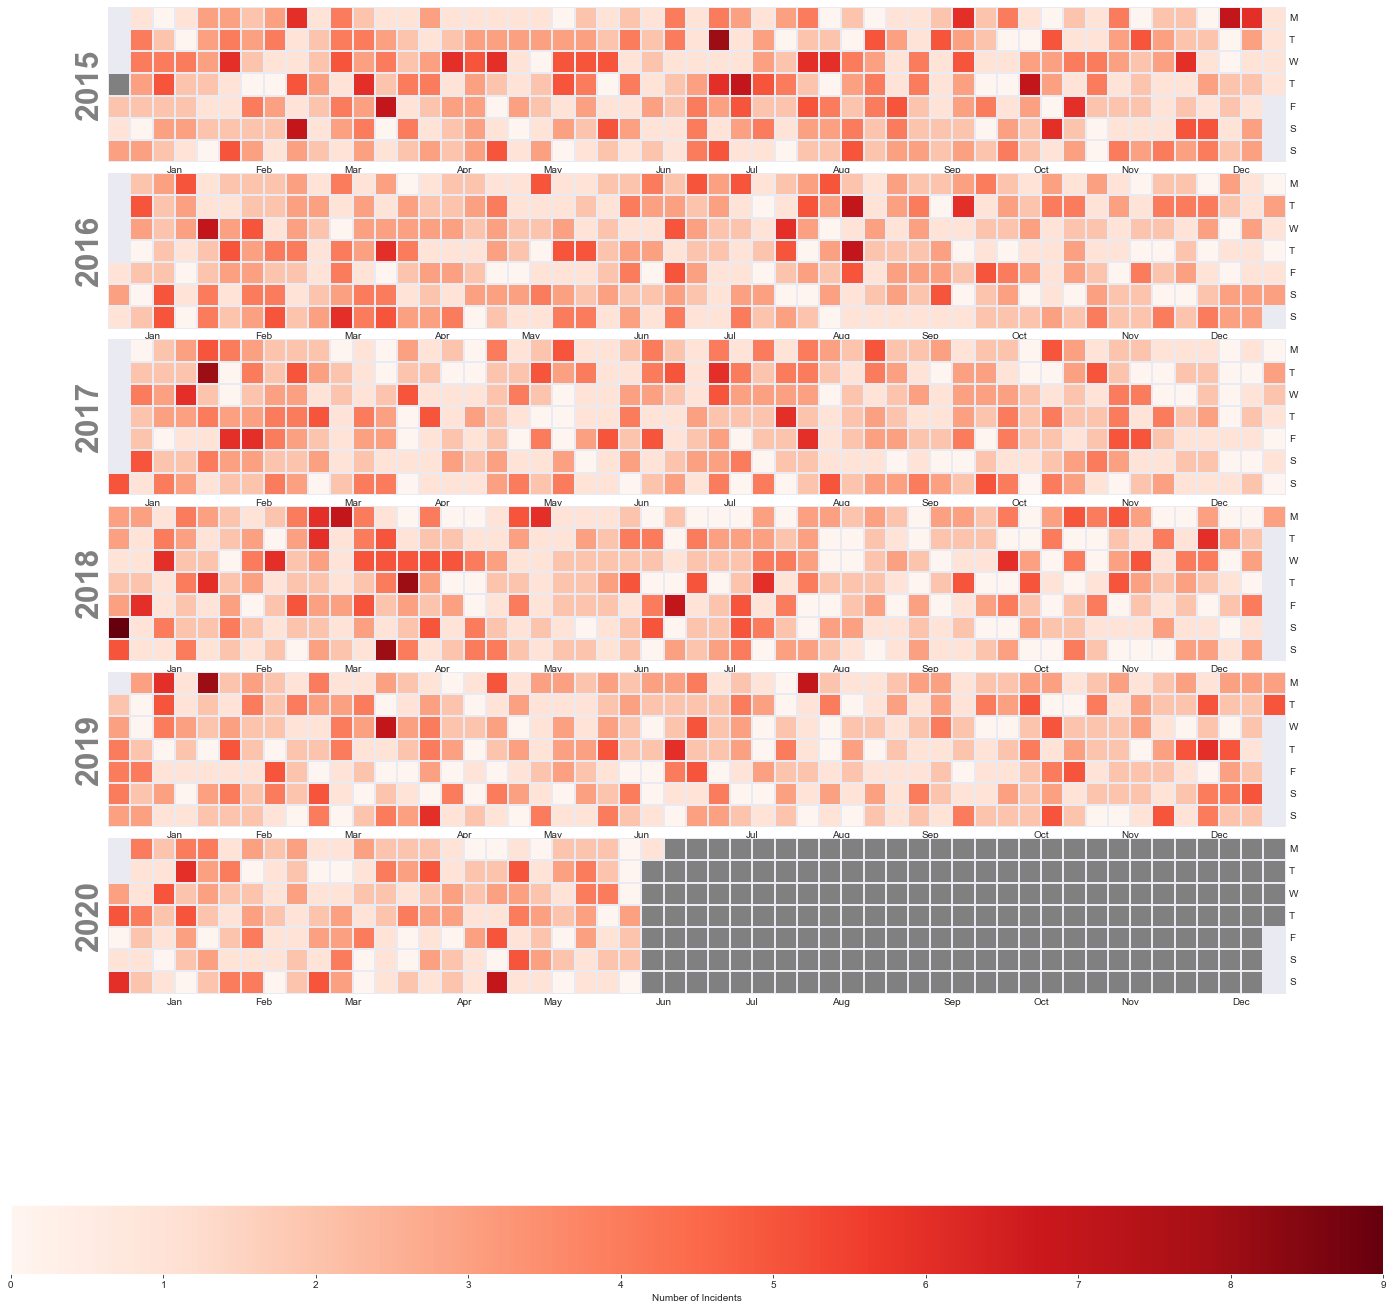

In [20]:
fig , ax = calmap.calendarplot(date_df, monthticks=1, daylabels='MTWTFSS',fillcolor='grey', linewidth=1, fig_kws=dict(figsize=(20,20)))

fig.colorbar(ax[0].get_children()[1], ax=ax, cmap=plt.cm.get_cmap('Reds', 9), orientation='horizontal', label='Number of Incidents')

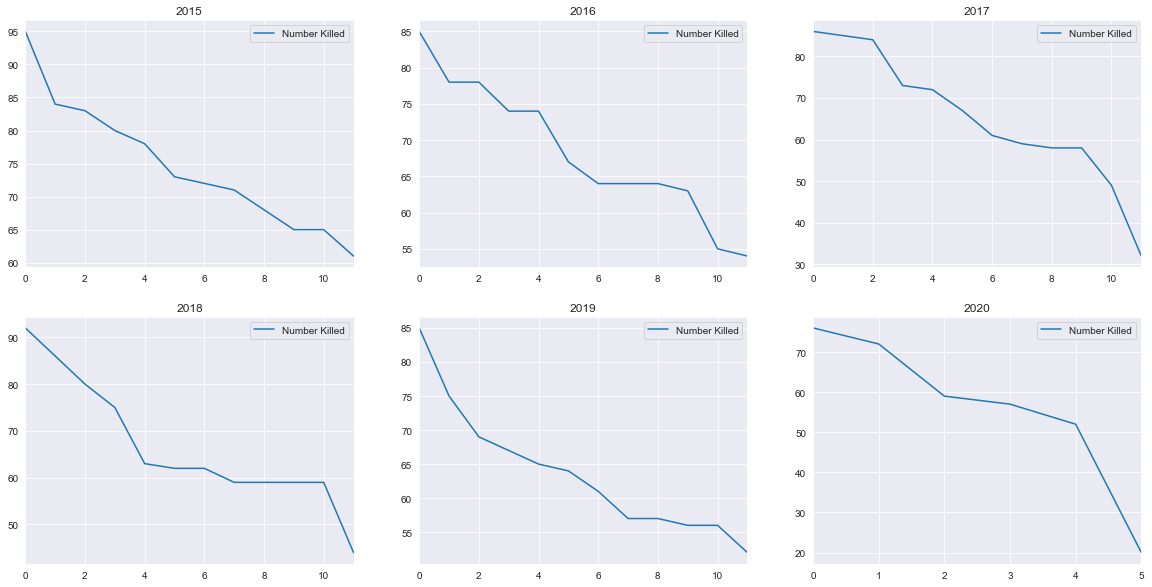

In [21]:
sub_2015 = df_clean[df_clean['year'] == 2015]
sub_2016 = df_clean[df_clean['year'] == 2016]
sub_2017 = df_clean[df_clean['year'] == 2017]
sub_2018 = df_clean[df_clean['year'] == 2018]
sub_2019 = df_clean[df_clean['year'] == 2019]
sub_2020 = df_clean[df_clean['year'] == 2020]

df_2015 = sub_2015['month'].value_counts().reset_index().rename(columns={'index':'Month',
                                                              'month':'Number Killed'})
df_2016 = sub_2016['month'].value_counts().reset_index().rename(columns={'index':'Month',
                                                              'month':'Number Killed'})
df_2017 = sub_2017['month'].value_counts().reset_index().rename(columns={'index':'Month',
                                                              'month':'Number Killed'})
df_2018 = sub_2018['month'].value_counts().reset_index().rename(columns={'index':'Month',
                                                              'month':'Number Killed'})
df_2019 = sub_2019['month'].value_counts().reset_index().rename(columns={'index':'Month',
                                                              'month':'Number Killed'})
df_2020 = sub_2020['month'].value_counts().reset_index().rename(columns={'index':'Month', 
                                                                         'month':'Number Killed'})


fig, axes = plt.subplots(2, 3,figsize=(20,10))
# fig.suptitle("Sharing Year as X")
df_2015.plot(ax=axes[0,0], title='2015')
df_2016.plot(ax=axes[0,1], title='2016')
df_2017.plot(ax=axes[0,2], title='2017')
df_2018.plot(ax=axes[1,0], title='2018')
df_2019.plot(ax=axes[1,1], title='2019')
df_2020.plot(ax=axes[1,2], title='2020')



In [22]:
weekdays = df_clean['day_of_week'].value_counts().reset_index().rename(columns={'index': 'Day of Week',
                                                                      'day_of_week':'Count'})


# weekdays
fig = go.Figure(data=go.Bar(x = weekdays['Day of Week'], 
                               y = weekdays['Count']))

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Day of the Week - Deaths',xaxis_title='Day of the Week',
                 yaxis_title='Count', title_x=0.5)

fig.show()

Most people are shot around mid of weekdays
Weekends proportion to weekdays are relatively smaller.

In [23]:
manner_of_death = ((df_clean.manner_of_death.value_counts()/len(df_clean)) * 100).round()

manner_df = manner_of_death.reset_index().rename(columns={'index': 'Manner of Death',
                                             'manner_of_death': '%'})

fig = px.pie(manner_df, values='%', names = 'Manner of Death')
fig.show()

 According to this [policy](https://www.aclu.org/sites/default/files/field_document/30099-30102%20Taser%20policy.pdf), the primary purpose for employing the Taser is to protect human lives and prevent injury to officers and citizens. Since it's less lethal, we can assume that a taser was deployed as a first sign of warning toward the aggressor. Only 5% of cases had a taser deployed then subsequently shot. On the contrary, 95% of cases were just shot. 
 
This calls into question on police tactics and funding. This metric can be used to formulate mandaotry tactical self-defense skill as a less-lethal approach to subdue/descalate situations to reduce deaths. 

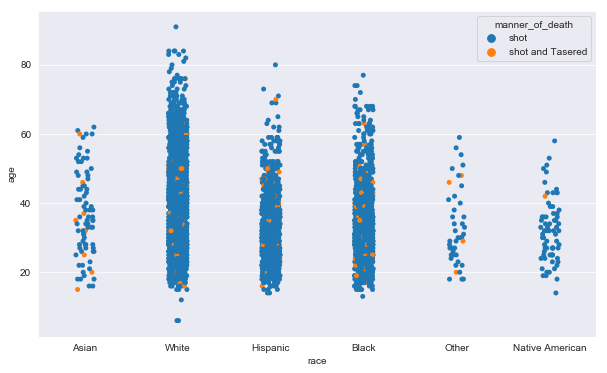

In [24]:
race_age_death = df_clean[['race','age','manner_of_death']].reset_index()
plt.figure(figsize=(10,6))
sns.stripplot(x='race',y='age', data=race_age_death, hue='manner_of_death')

### Weapon in Posession by Race 

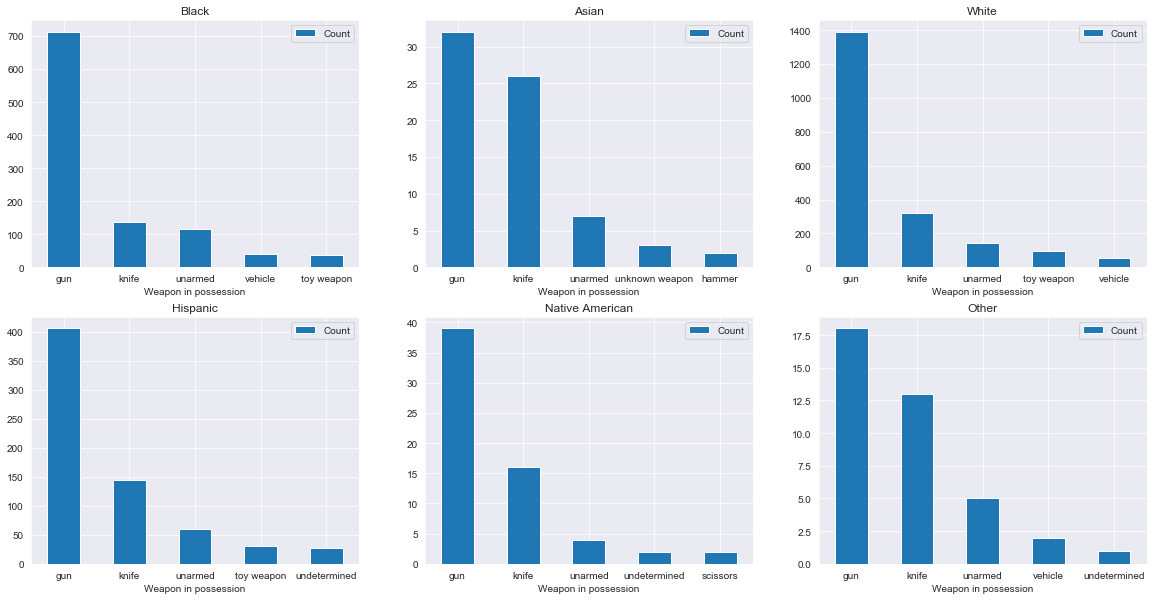

In [25]:
blacks = df_clean[df_clean['race'] == 'Black']
whites = df_clean[df_clean['race'] == 'White']
asians = df_clean[df_clean['race'] == 'Asian']
hispanics = df_clean[df_clean['race'] == 'Hispanic']
nativeamer = df_clean[df_clean['race'] == 'Native American']
o = df_clean[df_clean['race'] == 'Other']



b= blacks['armed'].value_counts().reset_index()[:5].rename(columns={'index':'Weapon in possession',
                                                                'armed': 'Count'})
a=asians['armed'].value_counts().reset_index()[:5].rename(columns={'index':'Weapon in possession',
                                                                'armed': 'Count'})
w=whites['armed'].value_counts().reset_index()[:5].rename(columns={'index':'Weapon in possession',
                                                                'armed': 'Count'})
h=hispanics['armed'].value_counts().reset_index()[:5].rename(columns={'index':'Weapon in possession',
                                                                'armed': 'Count'})
na= nativeamer['armed'].value_counts().reset_index()[:5].rename(columns={'index':'Weapon in possession',
                                                                'armed': 'Count'})

other= o['armed'].value_counts().reset_index()[:5].rename(columns={'index':'Weapon in possession',
                                                                'armed': 'Count'})



fig, axes = plt.subplots(2, 3,figsize=(20,10))

b.plot(ax=axes[0,0], title='Black', kind='bar', x='Weapon in possession', y='Count', rot=0)
a.plot(ax=axes[0,1], title='Asian', kind='bar', x='Weapon in possession', y='Count', rot=0)
w.plot(ax=axes[0,2], title='White', kind='bar', x='Weapon in possession', y='Count', rot=0)
h.plot(ax=axes[1,0], title='Hispanic', kind='bar', x='Weapon in possession', y='Count', rot=0)
na.plot(ax=axes[1,1], title='Native American', kind='bar', x='Weapon in possession', y='Count', rot=0)
other.plot(ax=axes[1,2], title='Other', kind='bar', x='Weapon in possession', y='Count', rot=0)




### Wordcloud of weapon types

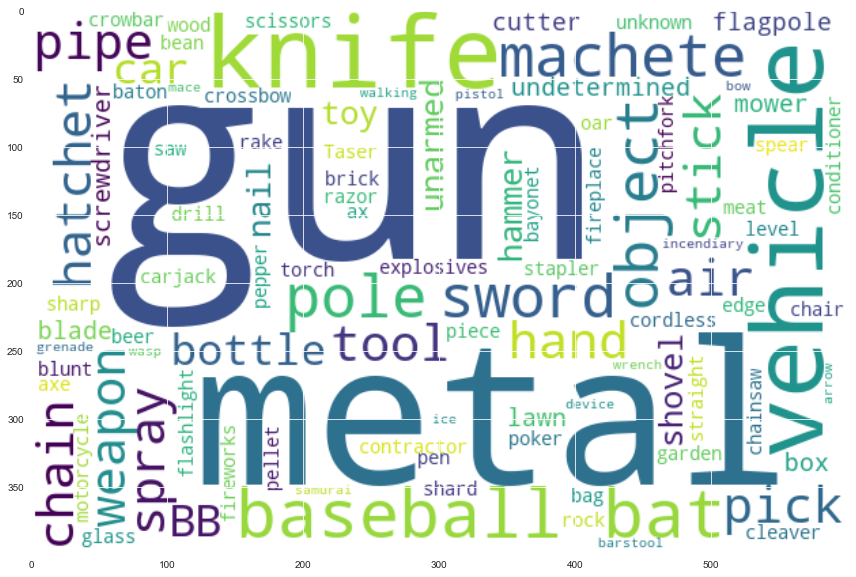

In [26]:
fig, (ax2) = plt.subplots(1,1,figsize=[17, 10])

weapon_type = list(df_clean['armed'].dropna().unique())
wordcloud = WordCloud(background_color='white',
                        width=600,height=400).generate(" ".join(weapon_type))
ax2.imshow(wordcloud,interpolation='bilinear')

Most of victims had gun,knife and metal object at time of incident.


In [27]:
unarmed = df_clean[df_clean['armed'] == 'unarmed']['race']
unarmed
fig = px.histogram(unarmed, x='race',color='race')
fig.show()

Around 10% of Black victims were unarmed compared to the 6% of White victims. 

In [28]:
w= (len(whites)/len(df_clean)) * 100
b = (len(blacks)/len(df_clean)) * 100
a = (len(asians)/len(df_clean)) * 100 
h = (len(hispanics)/len(df_clean)) * 100 
native = (len(nativeamer)/len(df_clean)) * 100 

print(f" Percent of Whites Killed: {w}")
print(f" Percent of Blacks Killed: {b}")
print(f" Percent of Asians Killed: {a}")
print(f" Percent of Hispanics Killed: {h}")
print(f" Percent of Native Americans Killed: {native}")


 Percent of Whites Killed: 51.216185496703794
 Percent of Blacks Killed: 26.460559218004093
 Percent of Asians Killed: 1.8867924528301887
 Percent of Hispanics Killed: 17.86769720390998
 Percent of Native Americans Killed: 1.5912707433507616


In [29]:
pop_df

Count  % of whole pop
Race                                      
White            249109947            66.7
Black             43336785            11.6
Native American    4098921             1.1
Asian             18687179             5.0
Hispanic          58498253            15.7

At first glance, Whites were shot at an astonishing rate of 51%. However, this should be taken with a grain of salt since White Americans comprise two-thirds of the US total population. African Americans, however, account for 26% of those fatally shot and killed by the police despite being just 12% of the U.S. population. 

In [30]:
white_state = df_clean[df_clean['race'] == 'White']['state'].value_counts().to_frame().reset_index().rename(columns={'index':'State',
                                                                                                                    'state':'Count'})
white_year = df_clean[df_clean['race'] == 'White']['year'].value_counts().to_frame().reset_index().rename(columns={'index':'Year',
                                                                                                                    'year':'Count'})

fig  = make_subplots(
    rows=2, cols=2, subplot_titles=("White victims in each states", "Yearly victims", "Distribution of Age",),
    column_widths=[0.6, 0.4],
    row_heights=[0.4, 0.6],
    specs=[[{"type": "Choropleth", "rowspan": 2}, {"type": "bar"}],
           [            None                    , {"type": "histogram"}]])

fig.add_trace(go.Choropleth(
    locations=white_state['State'],
    z=white_state['Count'].astype(float),
    locationmode='USA-states',
    colorscale='Blues',
    autocolorscale=False,
    text=white_state['State'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="Millions USD",showscale = False,
),row=1, col=1)

fig.add_trace(go.Bar(
    x= white_year['Year'], #[1, 2, 3, 4],
    y= white_year['Count'],  #[10, 11, 12, 13],
    text=white_year['Count'],
            textposition='inside',
    marker_color="lightblue",
    name="Death by year"
),row=1, col=2)

fig.add_trace(go.Histogram(x=df_clean[df_clean['race'] =='White']["age"],nbinsx=10,marker_color='blue',name="Age Distribution",xbins=dict(size=10),
    opacity=1),row=2, col=2)

fig.update_layout(
    title_text='White Americans shot by the Police (2015-2020)',
    title_x=0.5,
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.update_layout(
    template="plotly_dark",showlegend=False)
fig.show()

Since White American comprise nealy 66% of the US total population, they have a higher chance of being shot due to the sheer difference in population. 

California, Texas, and Florida have higher rates, possibly due to the size and density of each state. 
Most victims were between 30-50 years old.

### Black Americans Killed: Choropleth map, Frequency over Years, and Age Distriubtion

In [31]:
black_state = df_clean[df_clean['race'] == 'Black']['state'].value_counts().to_frame().reset_index().rename(columns={'index':'State',
                                                                                                                    'state':'Count'})
black_year = df_clean[df_clean['race'] == 'Black']['year'].value_counts().to_frame().reset_index().rename(columns={'index':'Year',
                                                                                                                    'year':'Count'})


In [32]:
fig  = make_subplots(
    rows=2, cols=2, subplot_titles=("Black victims in each states", "Yearly victims", "Distribution of Age",),
    column_widths=[0.6, 0.4],
    row_heights=[0.4, 0.6],
    specs=[[{"type": "Choropleth", "rowspan": 2}, {"type": "bar"}],
           [            None                    , {"type": "histogram"}]])

fig.add_trace(go.Choropleth(
    locations=black_state['State'],
    z=black_state['Count'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    text=black_state['State'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="Millions USD",showscale = False,
),row=1, col=1)

fig.add_trace(go.Bar(
    x= black_year['Year'], #[1, 2, 3, 4],
    y= black_year['Count'],  #[10, 11, 12, 13],
    text=black_year['Count'],
            textposition='inside',
    marker_color="lightsalmon",
    name="Death by year"
),row=1, col=2)

fig.add_trace(go.Histogram(x=df_clean[df_clean['race'] =='Black']["age"],nbinsx=10,marker_color='brown',name="Age Distribution",xbins=dict(size=10),
    opacity=1),row=2, col=2)

fig.update_layout(
    title_text='Black Americans shot by the Police (2015-2020)',
    title_x=0.5,
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.update_layout(
    template="plotly_dark",showlegend=False)
fig.show()

California,Texas and Florida has recorded most black people deaths.
There are more darker side on East side of US too. Perhaps those East Coast States have a higher African American population. 
Annually, the police kill an average of 212 African Americans every year. 

Sadly, there are 109 minors (10-19) who have been victims.
Montana, Wyoming, and North/South Dakotas were the only states with no reported deaths. 
Most of the victims were between 20-40 years old.


In [33]:
top_ten_cities = df_clean['City'].value_counts()[:10].reset_index().rename(columns={'index':'City',
                                                             'City': '# of Kills'})


In [34]:
#The HeatMapWithTime plugin takes the data in a specific format. 
# It takes the latitudes and longitudes in the form of nested arrays, so I used this loop to create a new list of coordinates 

lat_long_list = []
for i in range(1,31):
    temp=[]
    for index, instance in city_coords[city_coords['day'] == i].iterrows():
        temp.append([instance['Lat'],instance['Long']])
    lat_long_list.append(temp)

### Folium plugin to create a base map

In [35]:

fig7=Figure(width=850,height=550)
m7=folium.Map(location=[37.0902, -95.7129],zoom_start=10)
fig7.add_child(m7)

### HeatMapWithTime to view incidents over a course of an average month 

In [36]:
HeatMapWithTime(lat_long_list,radius=5,auto_play=True,position='bottomright').add_to(m7)
m7

### MarkerCluster Map of incident location and race of victim

In [68]:

locations = city_coords[['Lat','Long']].astype(float)

locationlist = locations.values.tolist()
locationlist


m = folium.Map(location=[37.0902, -95.7129], tiles='CartoDB positron', zoom_start=3)

marker_cluster = MarkerCluster().add_to(m)    

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=city_coords['City'][point]+', ' + city_coords['state'][point] + '<br></br>' + 'Victim Race: ' + city_coords['race'][point] + '<br></br>' + 'Weapon in possession: ' + city_coords['armed'][point]).add_to(marker_cluster)       
    
m

In [69]:
m.save('city_markermap.html')

### Heatmap representing hot-spots of police shooting

In [71]:
m1 = folium.Map(location=[39,-119], tiles = 'cartodbpositron', zoom_start=4)

HeatMap(data=city_coords[['Lat','Long']], radius=15).add_to(m1)
m1